In [59]:
import os
import sys
import pdb
import numpy as np
import scipy.interpolate
import scipy.io
import matlab.engine
import importlib

import matplotlib.pyplot as plt

import port
importlib.reload(port)

import room_simulator
importlib.reload(room_simulator)


<module 'room_simulator' from '/rdma/vast-rdma/vast/mcdermott/msaddler/francl_mcdermott_room_simulator/room_simulator.py'>

In [2]:
eng = matlab.engine.start_matlab();


In [105]:
src_loc = [1, 1, 4]
head_center = [2, 2, 5]
head_azimuth = -75
walls = [3, 5, 18]
wtypes = [3, 13, 13, 3, 26, 26]
sr = 44100
dur = 0.5
c = 344.5

log_dist = False
jitter = False
highpass = True
meas_sym = True

importlib.reload(port)

h_out, lead_zeros = port.room_impulse_hrtf(
    src_loc=src_loc,
    head_cent=head_center,
    head_azim=head_azimuth,
    use_m_sym=meas_sym,
    walls=walls,
    wtypes=wtypes,
    sr=sr,
    c=c,
    dur=dur,
    use_log_distance=log_dist,
    use_jitter=jitter,
    use_highpass=highpass)
print(lead_zeros)


42.00502772367945


In [106]:
h_out_matlab, lead_zeros_matlab = room_simulator.room_impulse_hrtf(
    np.array(src_loc),
    np.array(head_center),
    head_azimuth,
    np.array(walls),
    wtypes,
    meas_sym=meas_sym,
    f_samp=sr,
    c_snd=c,
    num_taps=int(sr*dur),
    log_dist=log_dist,
    jitter=jitter,
    highpass=highpass,
    dsply=0,
    eng=eng)
print(lead_zeros_matlab)


42.00502772367945


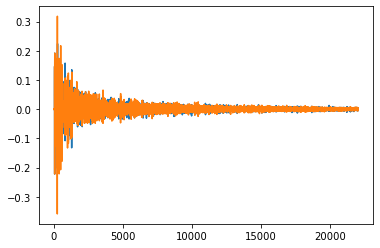

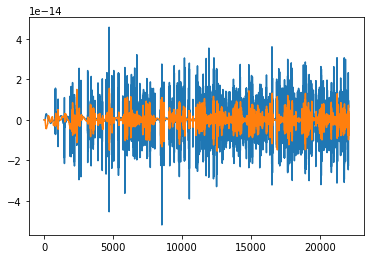

In [107]:
fig, ax = plt.subplots()
ax.plot(h_out)
plt.show()

fig, ax = plt.subplots()
ax.plot(h_out[1:] - h_out_matlab[:-1])
plt.show()


In [44]:
import port
import importlib
importlib.reload(port)

h_out, lead_zeros = port.room_impulse_hrtf(jitter=False, meas_sym=1)
print('END')


END


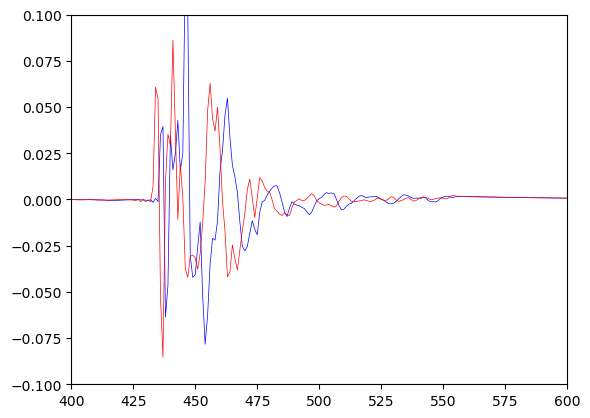

In [46]:
fig, ax = plt.subplots()
ax.plot(h_out[:, 0], 'b', lw=0.5)
ax.plot(h_out[:, 1], 'r', lw=0.5)
ax.set_xlim([400, 600])
ax.set_ylim([-0.1, 0.1])
plt.show()


In [14]:
fn = 'HRTFs/elev0/H0e140a.wav'
sr, y = scipy.io.wavfile.read(fn)
print(sr)

import soundfile as sf
y, sr = sf.read(fn)
print(y.max())


44100
0.41558837890625
